### DNN MODEL

In [ ]:
dnn_train_x = train_scaled[['PM25', 'O3', 'NO2', 'SO2', 'tem', 'rain', 'wind_x', 'wind_y', 'hum',
       'press', 'cloud', 'ammonia', 'toluen', 'methyle']]
dnn_train_y = x_train[['tomm_pm']]
dnn_valid_x = valid_scaled[['PM25', 'O3', 'NO2', 'SO2', 'tem', 'rain', 'wind_x', 'wind_y', 'hum',
       'press', 'cloud', 'ammonia', 'toluen', 'methyle']]
dnn_valid_y = x_valid[['tomm_pm']]
dnn_test_x = test_scaled[['PM25', 'O3', 'NO2', 'SO2', 'tem', 'rain', 'wind_x', 'wind_y', 'hum',
       'press', 'cloud', 'ammonia', 'toluen', 'methyle']]
dnn_test_y = x_test[['tomm_pm']]

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow import keras
#random seed를 정해 random값 고정하기

tf.random.set_seed(1) #1

dnn_model = tf.keras.models.Sequential()
dnn_model.add(Dense(64,
               input_shape=(dnn_train_x.shape[1],),
               activation='relu'))
dnn_model.add(Dense(32, activation='relu'))
dnn_model.add(Dense(1))

dnn_model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.01))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_lr=0.00001)
checkpoint_cb = keras.callbacks.ModelCheckpoint('dnn.h5')
early_stop = EarlyStopping(monitor='val_loss',patience=100, restore_best_weights=True)

history = dnn_model.fit(dnn_train_x, [dnn_train_y], epochs=10000,
                    validation_data=(dnn_valid_x, [dnn_valid_y]),
                    batch_size=64,
                    callbacks=[early_stop, checkpoint_cb, reduce_lr])

total_loss, main_loss = dnn_model.evaluate(dnn_test_x, [dnn_test_y])

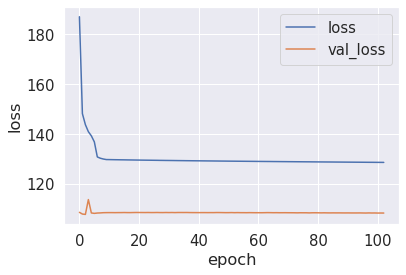

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
pred = dnn_model.predict([dnn_test_x])
print('Loss', dnn_model.evaluate(dnn_test_x, [dnn_test_y]))

233/233 [==============================] - 0s 1ms/step - loss: 120.9020 - mae: 7.6500
Loss [120.90204620361328, 7.649995803833008]


#### DNN 그래프

In [ ]:
dnn_model.predict([dnn_test_x])

array([[20.396196],
       [22.062029],
       [22.698713],
       ...,
       [23.48496 ],
       [22.206652],
       [22.378115]], dtype=float32)

In [ ]:
#예측 결과값
test_10days = dnn_test_x
dnn_10days = pd.DataFrame(dnn_model.predict([test_10days]))
#실제 값
actual = dnn_test_y
actual = actual.reset_index()

dnn_10days['actual'] = actual['tomm_pm']

dnn_date = air_test[24:]
dnn_date = dnn_date.reset_index()
dnn_10days['date'] = dnn_date['date']

In [ ]:
# 일별 그래프를 위해 date 변환
dnn_10days['daily'] = dnn_10days['date'].astype(str).str[:10]
dnn_10days['daily'] = pd.to_datetime(dnn_10days['daily'])
dnn_10days = dnn_10days.dropna(how='any')
print(dnn_10days.columns)

Index([0, 'actual', 'date', 'daily'], dtype='object')


In [ ]:
dnn_10days.columns

Index([0, 'actual', 'date', 'daily'], dtype='object')

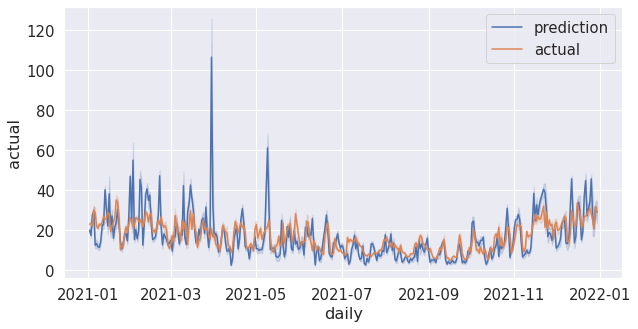

In [ ]:
plt.figure(figsize=(10, 5))
sns.lineplot(data = dnn_10days, x = 'daily', y = dnn_10days.actual)
sns.lineplot(data = dnn_10days, x= 'daily', y = dnn_10days[0])
plt.legend(['prediction', 'actual'])

### RNN MODEL (Simple RNN) 

In [ ]:
from tensorflow.keras.layers import SimpleRNN

tf.random.set_seed(12) #10

rnn_model = tf.keras.models.Sequential()
rnn_model.add(SimpleRNN(64,
               input_shape=(x_train_multi.shape[1],x_train_multi.shape[2]),
               activation='tanh'))
rnn_model.add(Dropout(0.2))
rnn_model.add(Dense(32, activation='relu'))
rnn_model.add(Dense(24))

rnn_model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=0.00001)
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm.h5', mode='min')
early_stop = EarlyStopping(monitor='val_loss',patience=300, restore_best_weights=True)

history = rnn_model.fit(x_train_multi, [y_train_multi], epochs=10000,
                    validation_data=(x_val_multi, [y_val_multi]),
                    batch_size=6,
                    callbacks=[early_stop,  checkpoint_cb])

total_loss, main_loss = rnn_model.evaluate(x_test_multi, [y_test_multi])

Epoch 1/10000
53/53 [==============================] - 3s 27ms/step - loss: 530.9360 - mae: 18.0122 - val_loss: 348.6922 - val_mae: 15.0144
Epoch 2/10000
53/53 [==============================] - 1s 16ms/step - loss: 361.2133 - mae: 13.7070 - val_loss: 166.9896 - val_mae: 9.3130
Epoch 3/10000
53/53 [==============================] - 1s 17ms/step - loss: 203.2453 - mae: 10.0041 - val_loss: 129.8199 - val_mae: 8.6261
Epoch 4/10000
53/53 [==============================] - 1s 17ms/step - loss: 181.5382 - mae: 9.8451 - val_loss: 125.0508 - val_mae: 8.6091
Epoch 5/10000
53/53 [==============================] - 1s 18ms/step - loss: 172.4212 - mae: 9.7097 - val_loss: 119.1873 - val_mae: 8.3734
Epoch 6/10000
53/53 [==============================] - 1s 17ms/step - loss: 168.0414 - mae: 9.5579 - val_loss: 122.8927 - val_mae: 8.5935
Epoch 7/10000
53/53 [==============================] - 1s 14ms/step - loss: 166.3692 - mae: 9.4721 - val_loss: 107.4081 - val_mae: 7.8134
Epoch 8/10000
53/53 [=========

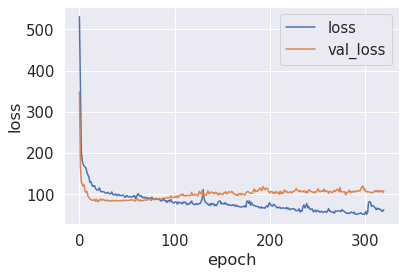

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
pred = rnn_model.predict([x_test_multi])
print('Loss', rnn_model.evaluate(x_test_multi, [y_test_multi]))

10/10 [==============================] - 0s 3ms/step - loss: 58.7475 - mae: 5.8394
Loss [58.74748229980469, 5.83936882019043]


In [ ]:
rnn_month_1 = rnn_model.predict(x_test_multi)[:, :1]
rnn_month_df_1 = pd.DataFrame(rnn_month_1)
rnn_month_1.shape

(308, 1)

In [ ]:
# test에 대한 prediction 결과나열
for i in range(1, 24):
    rnn_month_df_1['month_{}'.format(i)] = rnn_model.predict(x_test_multi)[:, i:i+1]

rnn_month_df_2 = rnn_month_df_1.transpose()

In [ ]:
pre = []
def make_df(dataframe):
  dataframe = dataframe
  for i in range(len(dataframe.columns)):
    result = dataframe.iloc[:,i]
    pre.append(result)
    pre1 = pd.concat(pre, ignore_index=True)
  return pre1

In [ ]:
rnn_month_df_3 = make_df(rnn_month_df_2)
rnn_month_df_3

0       15.583266
1       15.454368
2       14.859610
3       16.827951
4       16.043518
          ...    
7387    22.922485
7388    22.234966
7389    23.378057
7390    22.373392
7391    22.750921
Length: 7392, dtype: float32

In [ ]:
# prediction 결과의 날짜는 1월 2일부터
rnn_air_date = air_test['date'][24:-24]
rnn_air_date = rnn_air_date.reset_index()
rnn_air_date.head(2)

,index,date
0,24,2021-01-02 00:00:00
1,25,2021-01-02 01:00:00


In [ ]:
rnn_air_date['value'] = rnn_month_df_3
# 실제 관측값
actual = test_y[24:-24]
rnn_air_date['actual'] = actual

In [ ]:
# 실제 관측값 & 모델 예측값
rnn_air_date.columns

Index(['index', 'date', 'value', 'actual'], dtype='object')

In [ ]:
rnn_air_date['actual'] = rnn_air_date['actual'].astype(float)

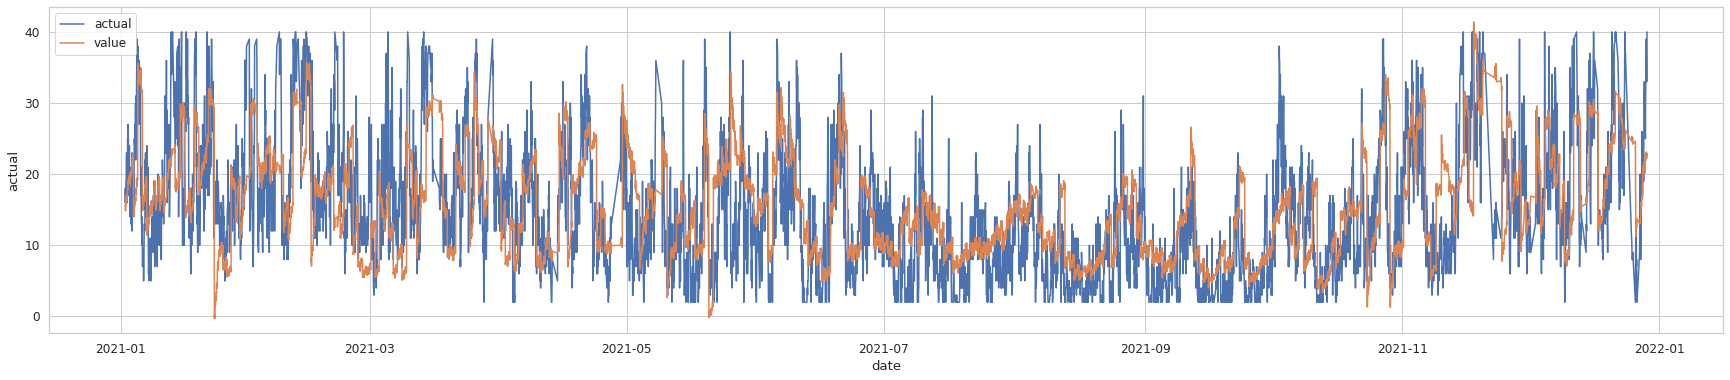

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))
sns.lineplot(data = rnn_air_date, x=rnn_air_date['date'], y= rnn_air_date['actual'])
sns.lineplot(data = rnn_air_date, x=rnn_air_date['date'], y= rnn_air_date['value'])
plt.legend(['actual','value'])

In [ ]:
#Monthly data
rnn_monthly_date = rnn_air_date['date'].astype(str).str[:7]
rnn_air_date['monthly_date'] = rnn_monthly_date

#hourly data
rnn_time = rnn_air_date['date'].astype(str).str[11:13]
rnn_air_date['hour'] = rnn_time

#daily data
rnn_daily_new_date = rnn_air_date['date'].astype(str).str[:10]
rnn_air_date['daily_new_date'] = rnn_daily_new_date
rnn_air_date['daily_new_date'] = pd.to_datetime(rnn_air_date['daily_new_date'])

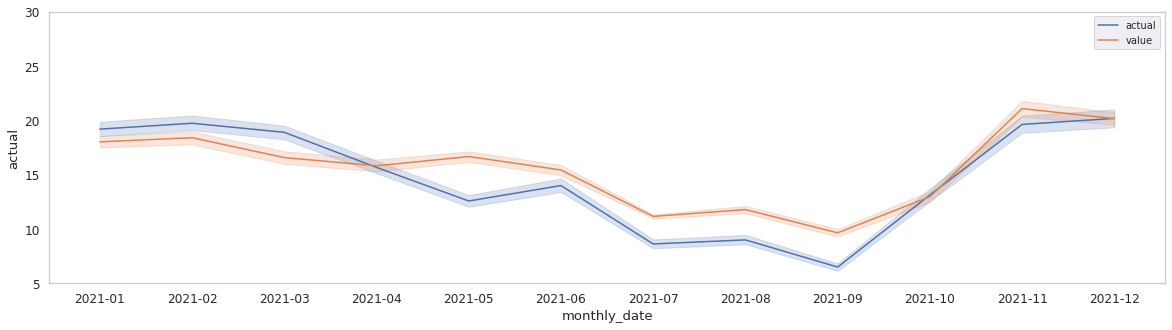

In [ ]:
# Monthly graph
plt.figure(figsize=(20, 5))
plt.ylim(5, 30)
plt.grid(False)
sns.set(font_scale = 0.9)

sns.lineplot(data = rnn_air_date, x=rnn_air_date['monthly_date'], y= rnn_air_date['actual'])
sns.lineplot(data = rnn_air_date, x=rnn_air_date['monthly_date'], y= rnn_air_date['value'])
plt.legend(['actual','value'])

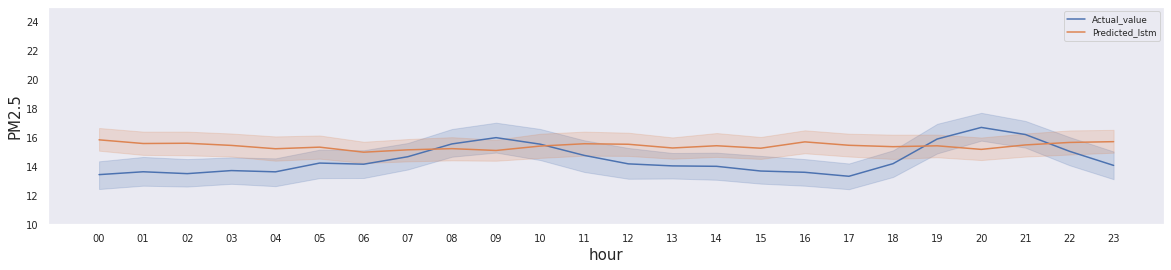

In [ ]:
#Hourly graph
plt.figure(figsize=(20, 4))
plt.ylim(10, 25)
plt.grid(False)
sns.set(font_scale = 0.8)

graph = sns.lineplot(data = rnn_air_date, x=rnn_air_date['hour'], y= rnn_air_date['actual'])
graph_2 = sns.lineplot(data = rnn_air_date, x=rnn_air_date['hour'], y= rnn_air_date['value'])
graph.set_xlabel('hour', fontsize = 15)
graph.set_ylabel('PM2.5', fontsize = 15)
plt.legend(labels = ['Actual_value', 'Predicted_lstm'])

In [ ]:
rnn_air_date['dnn'] = dnn_10days[:-24][0]
rnn_air_date.head()

,index,date,value,actual,monthly_date,hour,daily_new_date,dnn
0,24,2021-01-02 00:00:00,15.583266,18.0,2021-01,00,2021-01-02,25.006290
1,25,2021-01-02 01:00:00,15.454368,16.0,2021-01,01,2021-01-02,25.162521
2,26,2021-01-02 02:00:00,14.859610,18.0,2021-01,02,2021-01-02,25.827261
3,27,2021-01-02 03:00:00,16.827951,18.0,2021-01,03,2021-01-02,26.032608
4,28,2021-01-02 04:00:00,16.043518,17.0,2021-01,04,2021-01-02,28.142597


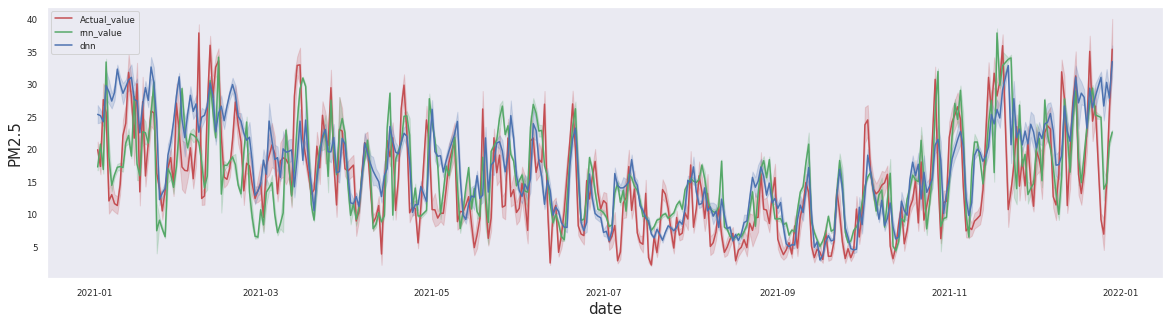

In [ ]:
# Daily graph
plt.figure(figsize=(20, 5))
plt.grid(False)

graph = sns.lineplot(data = rnn_air_date, x=rnn_air_date['daily_new_date'], y= rnn_air_date['actual'], color = 'r')
graph_2 = sns.lineplot(data = rnn_air_date, x=rnn_air_date['daily_new_date'], y= rnn_air_date['value'], color='g')
graph_3 = sns.lineplot(data = rnn_air_date, x=rnn_air_date['daily_new_date'], y = rnn_air_date['dnn'], color='b')
graph.set_xlabel('date', fontsize = 15)
graph.set_ylabel('PM2.5', fontsize = 15)
plt.legend(['Actual_value', 'rnn_value', 'dnn'])

### LSTM MODEL

In [ ]:
# LSTM
from tensorflow import keras
import tensorflow as tf
print('tf_version:',tf.__version__)
from tensorflow.python.client import device_lib
device_lib.list_local_devices()
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout

tf.random.set_seed(1)

model = tf.keras.models.Sequential()
model.add(LSTM(64,
               input_shape=(x_train_multi.shape[1], x_train_multi.shape[2]),
               activation='tanh',
               return_sequences=False))
#model.add(LSTM(32, activation='tanh', return_sequences=False))
model.add(Dense(32, activation='relu'))
model.add(Dense(24))

model.compile(loss='mse', metrics=['mae'], optimizer=keras.optimizers.Adam(learning_rate=0.01))

tf_version: 2.8.2


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow import keras

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4, min_lr=0.000001)
checkpoint_cb = keras.callbacks.ModelCheckpoint('lstm.h5', mode='min')
early_stop = EarlyStopping(monitor='val_loss',patience=400, restore_best_weights=True)

history = model.fit(x_train_multi, [y_train_multi], epochs=10000,
                    validation_data=(x_val_multi, [y_val_multi]),
                    batch_size=6,
                    callbacks=[early_stop, reduce_lr, checkpoint_cb])

total_loss, main_loss = model.evaluate(x_test_multi, [y_test_multi])

Epoch 1/10000
53/53 [==============================] - 3s 21ms/step - loss: 295.5211 - mae: 12.4950 - val_loss: 108.1908 - val_mae: 7.9186 - lr: 0.0100
Epoch 2/10000
53/53 [==============================] - 1s 12ms/step - loss: 175.3252 - mae: 9.7583 - val_loss: 95.4674 - val_mae: 6.9530 - lr: 0.0100
Epoch 3/10000
53/53 [==============================] - 1s 12ms/step - loss: 139.6355 - mae: 8.4091 - val_loss: 89.5429 - val_mae: 6.9538 - lr: 0.0100
Epoch 4/10000
53/53 [==============================] - 1s 12ms/step - loss: 127.1032 - mae: 8.0167 - val_loss: 84.2864 - val_mae: 6.5021 - lr: 0.0100
Epoch 5/10000
53/53 [==============================] - 1s 12ms/step - loss: 118.2040 - mae: 7.7455 - val_loss: 82.3588 - val_mae: 6.7453 - lr: 0.0100
Epoch 6/10000
53/53 [==============================] - 1s 12ms/step - loss: 119.6730 - mae: 7.6887 - val_loss: 143.1072 - val_mae: 8.3508 - lr: 0.0100
Epoch 7/10000
53/53 [==============================] - 1s 12ms/step - loss: 144.2541 - mae: 8.154

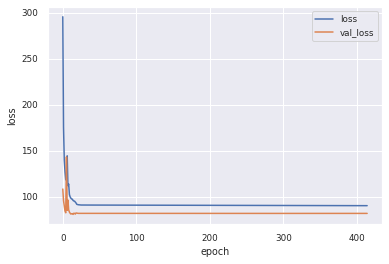

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss', 'val_loss'])
plt.show()

In [ ]:
pred = model.predict([x_test_multi])
print('Loss', model.evaluate(x_test_multi, [y_test_multi]))

10/10 [==============================] - 0s 6ms/step - loss: 52.7423 - mae: 5.6125
Loss [52.74229431152344, 5.61245584487915]


### Graph

In [ ]:
month_1 = model.predict(x_test_multi)[:, :1]
month_df_1 = pd.DataFrame(month_1)
month_1.shape

(308, 1)

In [ ]:
# test에 대한 prediction 결과나열
for i in range(1, 24):
    month_df_1['month_{}'.format(i)] = model.predict(x_test_multi)[:, i:i+1]

month_df_2 = month_df_1.transpose()

In [ ]:
pre = []
def make_df(dataframe):
  dataframe = dataframe
  for i in range(len(dataframe.columns)):
    result = dataframe.iloc[:,i]
    pre.append(result)
    pre1 = pd.concat(pre, ignore_index=True)
  return pre1

In [ ]:
month_df_3 = make_df(month_df_2)
month_df_3

0       17.010015
1       17.749788
2       18.189295
3       18.302982
4       18.358110
          ...    
7387    19.073704
7388    18.896151
7389    18.751446
7390    18.586414
7391    19.289743
Length: 7392, dtype: float32

In [ ]:
# prediction 결과의 날짜는 1월 2일부터
air_date = air_test['date'][24:-24]
air_date = air_date.reset_index()
air_date.head(2)

,index,date
0,24,2021-01-02 00:00:00
1,25,2021-01-02 01:00:00


In [ ]:
air_date['value'] = month_df_3
# 실제 관측값
actual = test_y[24:-24]
air_date['actual'] = actual

In [ ]:
# 실제 관측값 & 모델 예측값
air_date

,index,date,value,actual
0,24,2021-01-02 00:00:00,17.010015,18.0
1,25,2021-01-02 01:00:00,17.749788,16.0
2,26,2021-01-02 02:00:00,18.189295,18.0
3,27,2021-01-02 03:00:00,18.302982,18.0
4,28,2021-01-02 04:00:00,18.358110,17.0
...,...,...,...,...
7384,7408,2021-12-28 19:00:00,18.783192,32.0
7385,7409,2021-12-28 22:00:00,18.941086,39.0
7386,7410,2021-12-29 00:00:00,19.242744,33.0
7387,7411,2021-12-29 01:00:00,19.073704,33.0


In [ ]:
air_date['actual'] = air_date['actual'].astype(float)

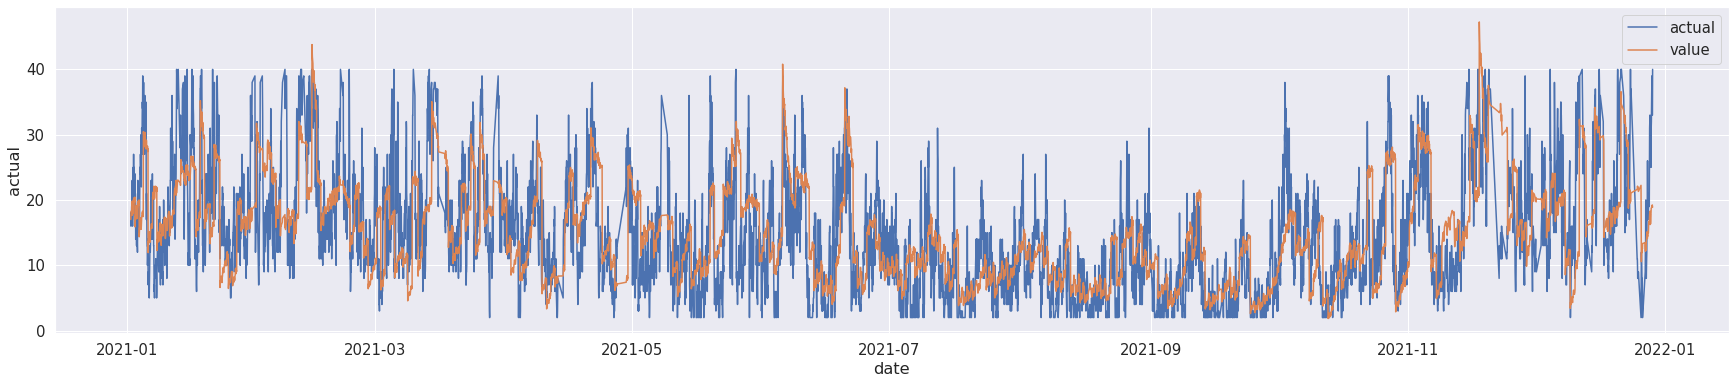

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 6))
sns.lineplot(data = air_date, x=air_date['date'], y= air_date['actual'])
sns.lineplot(data = air_date, x=air_date['date'], y= air_date['value'])
plt.legend(['actual','value'])

In [ ]:
#Monthly data
monthly_date = air_date['date'].astype(str).str[:7]
air_date['monthly_date'] = monthly_date

#hourly data
time = air_date['date'].astype(str).str[11:13]
air_date['hour'] = time

#daily data
daily_new_date = air_date['date'].astype(str).str[:10]
air_date['daily_new_date'] = daily_new_date
air_date['daily_new_date'] = pd.to_datetime(air_date['daily_new_date'])

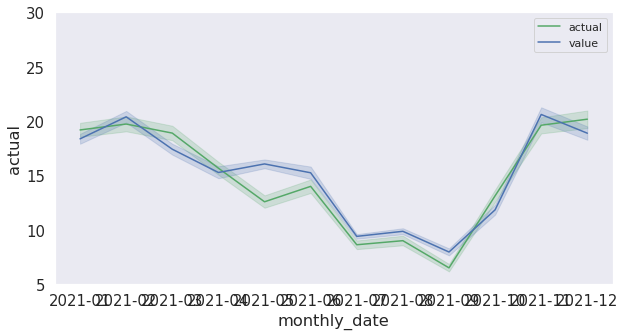

In [ ]:
# Monthly graph
plt.figure(figsize=(10, 5))
plt.ylim(5, 30)
plt.grid(False)
sns.set(font_scale = 1.0)

sns.lineplot(data = air_date, x=air_date['monthly_date'], y= air_date['actual'], color='g')
sns.lineplot(data = air_date, x=air_date['monthly_date'], y= air_date['value'], color ='b')

plt.legend(['actual','value'])

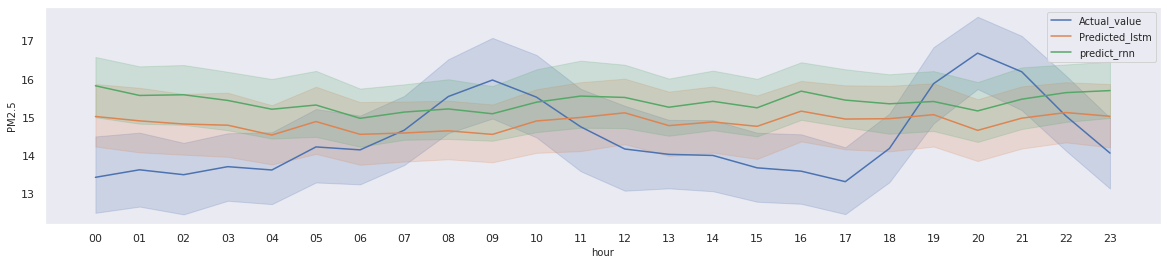

In [ ]:
#Hourly graph
plt.figure(figsize=(20, 4))
plt.grid(False)
sns.set(font_scale = 0.9)

graph = sns.lineplot(data = air_date, x=air_date['hour'], y= air_date['actual'])
graph_2 = sns.lineplot(data = air_date, x=air_date['hour'], y= air_date['value'])
graph_2 = sns.lineplot(data = rnn_air_date, x=rnn_air_date['hour'], y= rnn_air_date['value'])

graph.set_xlabel('hour', fontsize = 10)
graph.set_ylabel('PM2.5', fontsize = 10)
plt.legend(labels = ['Actual_value', 'Predicted_lstm', 'predict_rnn'])

In [ ]:
# Daily graph
#plt.figure(figsize=(25, 4))
#plt.grid(False)
#sns.set(font_scale = 0.9)

#graph = sns.lineplot(data = air_date, x=air_date['daily_new_date'], y= air_date['actual'])
#graph_2 = sns.lineplot(data = air_date, x=air_date['daily_new_date'], y= air_date['value'])
#graph.set_xlabel('date', fontsize = 15)
#graph.set_ylabel('PM2.5', fontsize = 15)
#plt.legend(['Actual_value', 'lstm_value'])

In [ ]:
rnn_air_date.columns

Index(['index', 'date', 'value', 'actual', 'monthly_date', 'hour',
       'daily_new_date', 'dnn'],
      dtype='object')

In [ ]:
rnn_air_date['dnn'] = dnn_model.predict([dnn_test_x])[:-48]

In [ ]:
air_date['rnn'] = rnn_air_date['value']
air_date['dnn'] = rnn_air_date['dnn']
air_date.head()

,index,date,value,actual,monthly_date,hour,daily_new_date,rnn,dnn
0,24,2021-01-02 00:00:00,17.010015,18.0,2021-01,00,2021-01-02,15.583266,23.634430
1,25,2021-01-02 01:00:00,17.749788,16.0,2021-01,01,2021-01-02,15.454368,25.557766
2,26,2021-01-02 02:00:00,18.189295,18.0,2021-01,02,2021-01-02,14.859610,26.684031
3,27,2021-01-02 03:00:00,18.302982,18.0,2021-01,03,2021-01-02,16.827951,25.742636
4,28,2021-01-02 04:00:00,18.358110,17.0,2021-01,04,2021-01-02,16.043518,28.009764


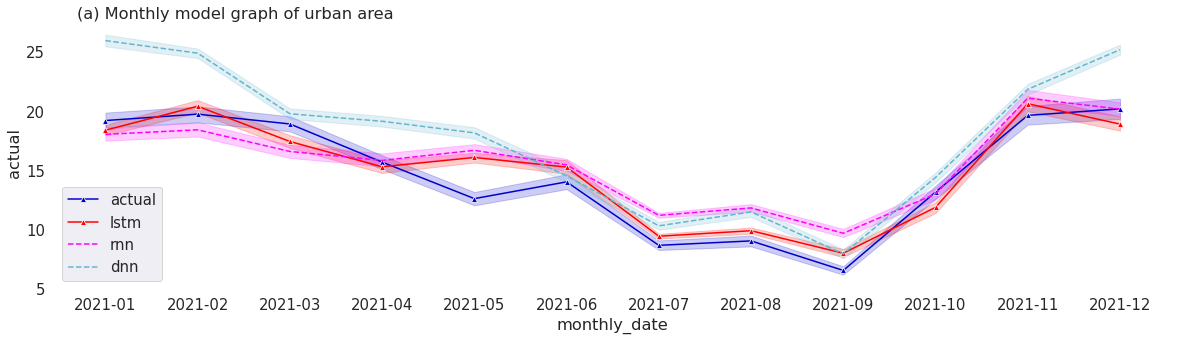

In [ ]:
# Monthly graph
plt.figure(figsize=(20, 5))
plt.ylim(5, 28)
plt.grid(False)
sns.set(font_scale = 1.35)
ax = plt.gca()
ax.set_facecolor('white')
graph.set_xlabel('hour', fontsize = 10)
graph.set_ylabel('PM2.5', fontsize = 10)
plt.title('(a) Monthly model graph of urban area',
          position = (0.1620, 0.97))
sns.lineplot(data = air_date, x=air_date['monthly_date'], y= air_date['actual'], color='mediumblue', marker = '^')
sns.lineplot(data = air_date, x=air_date['monthly_date'], y= air_date['value'], color ='red', marker = '^')
sns.lineplot(data = air_date, x = 'monthly_date',y = 'rnn', color = 'fuchsia',linestyle='--')
sns.lineplot(data = air_date, x = 'monthly_date', y = 'dnn',color = 'c', linestyle='--')
plt.legend(['actual','lstm','rnn','dnn'])